In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import lightning as L
from torchvision.models import vit_b_16, vit_b_32 # pretrained model
from torchsummary import summary
import torchmetrics
import cv2
import optuna
import joblib

import brain_tumor_dataset as btd

c:\Users\Andreas\anaconda3\envs\deep_learning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup data

In [2]:
# Define the transformation for the images
transform = transforms.Compose([
	transforms.Grayscale(num_output_channels=3),   # convert to 3 channels
	transforms.Resize((224, 224)),                 # resize to 224x224
	transforms.ToTensor(),
])

# Load your datasets with the defined transformations
train_dataset = btd.BrainTumorDataset(btd.TRAIN_DATA_PATH, transform=transform)
test_dataset = btd.BrainTumorDataset(btd.TEST_DATA_PATH, transform=transform)

val_size = len(test_dataset) // 2
test_size = len(test_dataset) - val_size
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [test_size, val_size])

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_dataset), len(test_dataset), len(val_dataset)

(5712, 656, 655)

# Setup classifier

In [3]:
# Define the PyTorch Lightning Module
class BrainTumorClassifier(L.LightningModule):
	def __init__(self, 
			  learning_rate=1e-3, 
			  patch_size=16,
			  batch_size=32,
			  pretrained_weights = "IMAGENET1K_V1"):
		super().__init__()
		# Initialize the model with the pre-trained ViT
		if patch_size == 16:
			self.model = vit_b_16(weights=pretrained_weights)
		elif patch_size == 32:
			self.model = vit_b_32(weights=pretrained_weights)

		self.model.heads = torch.nn.Linear(self.model.hidden_dim, 4)  # Modify for 4 classes

		# Define loss function and learning rate
		self.criterion = torch.nn.CrossEntropyLoss()
		self.learning_rate = learning_rate

		# Initialize accuracy metric for logging
		self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4)
		self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4)

		self.attention_maps = {}  # To store attention maps

	def forward(self, x):
		return self.model(x)

	def training_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
		self.train_accuracy(outputs, labels)
		self.log('train_acc', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True)

		return loss
	
	def validation_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('val_loss', loss, on_epoch=True, prog_bar=True)
		self.val_accuracy(outputs, labels)
		self.log('val_acc', self.val_accuracy, on_epoch=True, prog_bar=True)

		return loss

	def test_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('test_loss', loss, on_epoch=True, prog_bar=True)
		self.val_accuracy(outputs, labels)
		self.log('test_acc', self.val_accuracy, on_epoch=True, prog_bar=True)

		self.log_attention_maps(inputs, labels, outputs, batch_idx)  # Save attention maps

		return loss
	
	def configure_optimizers(self):
		return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
	
	def register_attention_hooks(self):
		"""Register hooks to capture attention maps."""
		self.attention_maps.clear()  # Reset attention maps

		def hook_fn(module, input, output, module_name):
			module_name = module_name.split(".")[2]  # Get the layer name
			self.attention_maps[module_name] = output[1]  # Save attention map
			# q, k, _ = input
			# self.attention_maps[module_name] = torch.nn.functional.softmax(q @ k.transpose(-2, -1))  # Save attention map

		# Register hooks on all MultiheadAttention layers
		for i, module in self.model.named_modules():
			if isinstance(module, torch.nn.MultiheadAttention):
				module.register_forward_hook(lambda module, input, output, module_name=i: hook_fn(module, input, output, module_name))
	
	def on_test_start(self):
		# Register the hook to each multi-head attention layer before testing
		self.register_attention_hooks()

	def log_attention_maps(self, inputs, labels, output, batch_idx):
			"""Log attention maps overlaid on the original image using Lightning's logger."""

			predicted_labels = [btd.BrainTumorDataset().idx_to_class[lbl.item()] for lbl in torch.argmax(output, dim=1)]
			batch_size = inputs.size(0)
			for i in range(batch_size):
				rollout_attention_map = torch.eye(self.attention_maps['encoder_layer_1'].size(-1))
				for _, attention in self.attention_maps.items():
					# Get the attention map for the first image in the batch
					attention_map = attention[i]  # Shape: [num_tokens, embedding_size]

					attention_map = attention_map + torch.eye(attention_map.size(-1))  # Add identity matrix
					attention_map /= attention_map.sum(dim=-1, keepdim=True)  # Normalize attention map
					if rollout_attention_map is None:
						rollout_attention_map = attention_map
					else:
						rollout_attention_map = torch.matmul(rollout_attention_map, attention_map)

				# class_token_embedding = class_token_embedding / torch.norm(class_token_embedding)
				num_patches_side = int((attention_map.size(0) - 1) ** 0.5)
				class_token_embedding = rollout_attention_map[0, 1:] # Shape: (embedding_size)
				attention_map = 1 - class_token_embedding.view(num_patches_side, num_patches_side, -1).clone()
				attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())
				# average_attention_map = average_attention_map / num_layers

				average_attention_map = attention_map.cpu().detach().numpy()
				average_attention_map = cv2.resize(average_attention_map, (inputs.size(2), inputs.size(3)))
				heatmap = cv2.applyColorMap(np.uint8(255 * average_attention_map), cv2.COLORMAP_JET)

				# Overlay the heatmap on the original image
				image = inputs[i].cpu().numpy().transpose(1, 2, 0)
				image = (image*255).astype(np.uint8)
				overlayed_image = cv2.addWeighted(image, 0.8, heatmap, 0.4, 0)

				# add class label
				label = labels[i].item()
				label = btd.BrainTumorDataset().idx_to_class[label]
				cv2.putText(overlayed_image, f"Real class: {label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
				cv2.putText(overlayed_image, f"Predicted class: {predicted_labels[i]}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

				# convert to chw
				overlayed_image = overlayed_image.transpose(2, 0, 1)

				# Create a blank image to place the original and overlayed images side by side
				combined_image = np.zeros((inputs.size(2), inputs.size(3) * 2, 3), dtype=np.uint8)

				# Place the original image on the left
				combined_image[:, :inputs.size(3), :] = image

				# Place the overlayed image on the right
				overlayed_image = overlayed_image.transpose(1, 2, 0)  # Convert back to HWC
				combined_image[:, inputs.size(3):, :] = overlayed_image

				# Convert back to CHW for logging
				combined_image = combined_image.transpose(2, 0, 1)

				# log to tensorboard
				self.logger.experiment.add_image(f'attn_map/batch_{batch_idx}/img_{i}', combined_image, self.current_epoch)

In [18]:
# Create the model instance
weights_path = "./logs/vit_pretrained/colab_run5/version_0/epoch-epoch=03-val_loss-val_loss=0.03.ckpt"
model = BrainTumorClassifier()
# model = BrainTumorClassifier.load_from_checkpoint(weights_path, map_location=model.device)

# Define callbacks
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
	monitor="val_loss",                     # Monitor validation loss
	mode = "min",                           # mode for monitored metric
	dirpath="checkpoints/",                   # Directory to save checkpoints
	filename="epoch-{epoch:02d}-val_loss-{val_loss:.2f}",  # Naming pattern
	save_top_k=-1,                          # Save all checkpoints
	every_n_epochs=1,                       # Save at every epoch
)

early_stopping_callback = L.pytorch.callbacks.EarlyStopping(
	monitor="val_loss",                     # Metric to monitor
	patience=5,                             # Stop training if no improvement for 5 epochs
	mode="min",                             # Stop when `val_loss` stops decreasing
)

logger = L.pytorch.loggers.TensorBoardLogger("logs", name="vit_pretrained")


# Define the PyTorch Lightning Trainer
trainer = L.Trainer(max_epochs=10, 
					accelerator="auto", 
					logger=logger,
					callbacks=[checkpoint_callback, early_stopping_callback])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
# Train the model
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [28]:
# Test the model
trainer.test(model, dataloaders=test_loader)

c:\Users\Andreas\anaconda3\envs\deep_learning\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 21/21 [03:22<00:00,  0.10it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9923780560493469     │
│         test_loss         │    0.03537702560424805    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.03537702560424805, 'test_acc': 0.9923780560493469}]

# Training (using Optuna)
Based on [this guide](https://medium.com/swlh/optuna-hyperparameter-optimization-in-pytorch-9ab5a5a39e77)

In [11]:
# Define the objective function for Optuna (the function to optimize)
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    patch_size = trial.suggest_categorical('patch_size', [16])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Create the model and data module with suggested hyperparameters
    model = BrainTumorClassifier(learning_rate=learning_rate,
                                 patch_size=patch_size,
                                 batch_size=batch_size)

	# Define callbacks
    checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
		monitor="val_loss",                     # Monitor validation loss
		mode = "min",                           # mode for monitored metric
		dirpath="checkpoints/",                   # Directory to save checkpoints
		filename="epoch-{epoch:02d}-val_loss-{val_loss:.2f}",  # Naming pattern
		save_top_k=-1,                          # Save all checkpoints
		every_n_epochs=1,                       # Save at every epoch
	)

    early_stopping_callback = L.pytorch.callbacks.EarlyStopping(
		monitor="val_loss",                     # Metric to monitor
		patience=5,                             # Stop training if no improvement for 5 epochs
		mode="min",                             # Stop when `val_loss` stops decreasing
	)

    logger = L.pytorch.loggers.TensorBoardLogger("logs", name="vit_pretrained")

    # Define the PyTorch Lightning Trainer
    trainer = L.Trainer(
        max_epochs=20,
        accelerator="auto",
        logger=logger,
        callbacks=[early_stopping_callback, checkpoint_callback],
    )

    # Train the model
    # trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    # save the model
    trainer.save_checkpoint(f"vit_pretrained_{trial.number}.ckpt")

    # Evaluate the model
    val_loss = trainer.callback_metrics["val_loss"].item()

    # report intermediate objective value
    trial.report(val_loss, step=trainer.current_epoch)

    # Handle pruning based on the intermediate value
    if trial.should_prune():
        raise optuna.TrialPruned()

    return val_loss

In [ ]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction="minimize", study_name="vit_pretrained")
study.optimize(objective, n_trials=12, show_progress_bar=True, n_jobs=3)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Model testing

In [34]:
import yaml

# setup the paths
root = "logs"
name = "vit_pretrained/colab_run5"
version = "version_6"

path = f"{root}/{name}/{version}"
weights_path = f"{path}/vit_pretrained_6.ckpt"
hparams_path = f"{path}/hparams.yaml"

# Load the hyperparameters
hparams = yaml.safe_load(open(hparams_path))

# Create the model and data module
model = BrainTumorClassifier(
    learning_rate=hparams["learning_rate"],
	patch_size=hparams["patch_size"],
	batch_size=hparams["batch_size"]
)

# Load the model weights
model = BrainTumorClassifier.load_from_checkpoint(weights_path)

In [5]:
# run test
logger = L.pytorch.loggers.TensorBoardLogger(root, name=name, version=version)
trainer = L.Trainer(logger=logger, accelerator="auto")

trainer.test(model, dataloaders=test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Andreas\anaconda3\envs\deep_learning\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 21/21 [03:12<00:00,  0.11it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9817073345184326     │
│         test_loss         │    0.07839883118867874    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.07839883118867874, 'test_acc': 0.9817073345184326}]

# Inspection of Tensorboard file

In [39]:
import json
# load loss and acc files from json
train_loss = json.load(open(f'{path}/{version}_train_loss.json', 'r'))
train_acc = json.load(open(f'{path}/{version}_train_acc.json', 'r'))
val_loss = json.load(open(f'{path}/{version}_val_loss.json', 'r'))
val_acc = json.load(open(f'{path}/{version}_val_acc.json', 'r'))

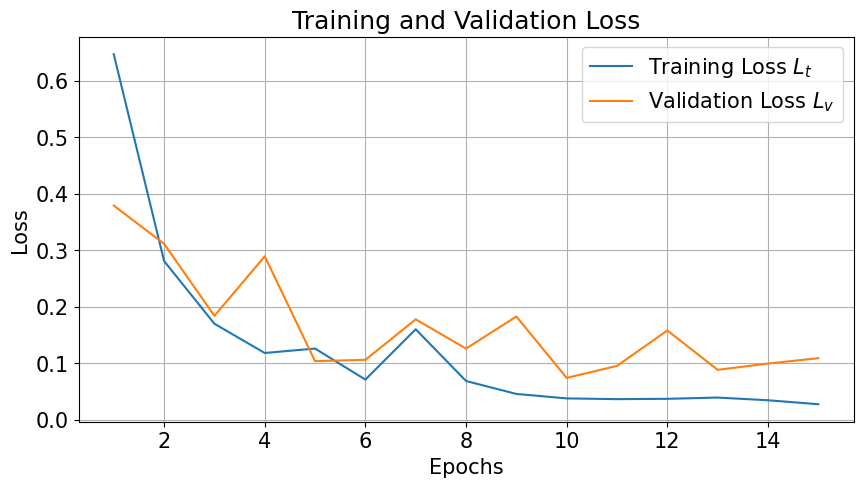

In [48]:
import matplotlib.pyplot as plt

# Extract the epoch numbers and loss values
epochs = list(range(1, len(train_loss) + 1))
train_loss_values = [loss[2] for loss in train_loss]
val_loss_values = [loss[2] for loss in val_loss]

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_values, label='Training Loss $L_t$')
plt.plot(epochs, val_loss_values, label='Validation Loss $L_v$')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.rcParams.update({'font.size': 15})
plt.show()

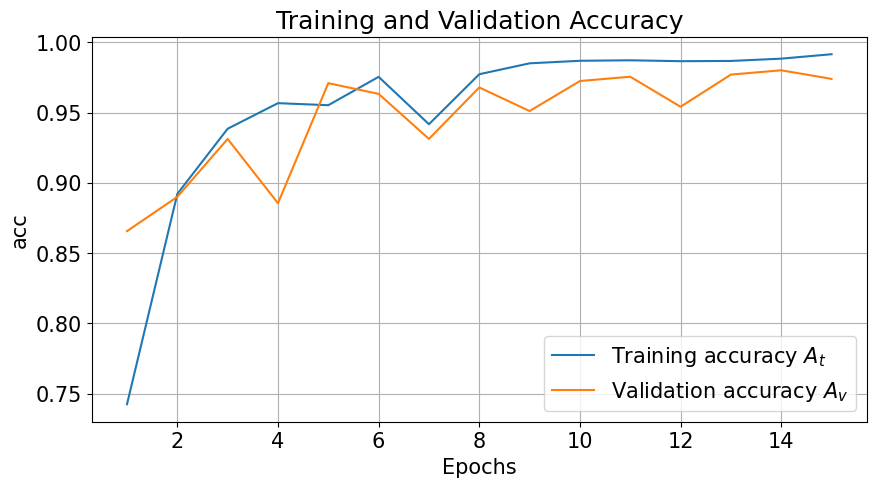

In [49]:
# Extract the epoch numbers and loss values
epochs = list(range(1, len(train_acc) + 1))
train_acc_values = [acc[2] for acc in train_acc]
val_acc_values = [acc[2] for acc in val_acc]

# Plot the training and validation acc
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_values, label='Training accuracy $A_t$')
plt.plot(epochs, val_acc_values, label='Validation accuracy $A_v$')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.rcParams.update({'font.size': 15})
plt.show()

# Inspection of Optuna results

In [5]:
# to load it:
# https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html
import joblib
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
# study_run1 = joblib.load("logs/vit_pretrained/colab_run1/vit_pretrained_study.pkl")
study = joblib.load("logs/vit_pretrained/colab_run5/vit_pretrained_study_2024-12-05-14-55.pkl")
print(study.best_trial.params)

{'learning_rate': 0.00016501192788890502, 'patch_size': 16, 'batch_size': 128}


In [7]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_learning_rate,params_patch_size,state
0,0,0.157173,2024-12-05 06:55:49.032475,2024-12-05 09:37:03.126183,0 days 02:41:14.093708,128,0.000322,16,COMPLETE
1,1,0.198278,2024-12-05 06:55:49.034102,2024-12-05 08:49:32.192154,0 days 01:53:43.158052,128,0.000428,16,COMPLETE
2,2,0.254228,2024-12-05 06:55:49.037257,2024-12-05 08:50:15.519120,0 days 01:54:26.481863,32,0.000580,16,COMPLETE
3,3,0.148939,2024-12-05 08:49:32.199556,2024-12-05 10:43:00.999844,0 days 01:53:28.800288,64,0.000277,16,COMPLETE
4,4,0.138225,2024-12-05 08:50:15.526563,2024-12-05 10:44:14.676744,0 days 01:53:59.150181,64,0.000305,16,COMPLETE
5,5,0.152461,2024-12-05 09:37:03.134107,2024-12-05 12:17:59.726110,0 days 02:40:56.592003,128,0.000244,16,COMPLETE
6,6,0.108762,2024-12-05 10:43:01.007439,2024-12-05 12:08:05.890919,0 days 01:25:04.883480,128,0.000165,16,COMPLETE
7,7,0.179275,2024-12-05 10:44:14.682528,2024-12-05 12:38:07.396795,0 days 01:53:52.714267,32,0.000674,16,PRUNED
8,8,0.309945,2024-12-05 12:08:05.897813,2024-12-05 13:33:48.374986,0 days 01:25:42.477173,32,0.000317,16,PRUNED
9,9,0.182242,2024-12-05 12:17:59.731745,2024-12-05 14:45:20.183836,0 days 02:27:20.452091,64,0.000909,16,PRUNED


In [8]:
plot_optimization_history(study)

In [18]:
fig = plot_parallel_coordinate(study, params=["learning_rate", "batch_size"])
# increase font size
fig.update_layout(font=dict(size=17))
fig.show()